In [11]:
!pip install numpy
!pip install accelerate -U
!pip install transformers[torch]
!pip install pytorch-accelerated

  Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.29.3
    Uninstalling accelerate-0.29.3:
      Successfully uninstalled accelerate-0.29.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-accelerated 0.1.49 requires accelerate==0.29.3, but you have accelerate 0.30.1 which is incompatible.


  Using cached accelerate-0.29.3-py3-none-any.whl (297 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.30.1
    Uninstalling accelerate-0.30.1:
      Successfully uninstalled accelerate-0.30.1


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Veri setini indirme ve yükleme
# data_path = "mtsamples.csv"
data_path = "mtsamples_new.csv"
data = pd.read_csv(data_path)

# Veri setini inceleyin
print(data.head())

# Örnek veri temizleme ve ön işleme
data = data.dropna(subset=['transcription', 'medical_specialty'])
data['label'] = data['medical_specialty'].astype('category').cat.codes

# Eğitim ve test veri setlerine ayırma
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['transcription'].values, data['label'].values, test_size=0.2, random_state=42
)


                                       transcription  \
0  2-D M-MODE: , ,1.  Left atrial enlargement wit...   
1  1.  The left ventricular cavity size and wall ...   
2  2-D ECHOCARDIOGRAM,Multiple views of the heart...   
3  DESCRIPTION:,1.  Normal cardiac chambers size....   
4  2-D STUDY,1. Mild aortic stenosis, widely calc...   

            medical_specialty  
0  Cardiovascular / Pulmonary  
1  Cardiovascular / Pulmonary  
2  Cardiovascular / Pulmonary  
3  Cardiovascular / Pulmonary  
4  Cardiovascular / Pulmonary  


In [25]:
from torch.utils.data import Dataset

class MedicalTranscriptionsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


In [26]:
# Veriyi tokenleştirme
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=512)

In [27]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

# Tokenizer ve modeli yükleme
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=len(data['label'].unique()))


train_encodings = tokenize_function(train_texts.tolist())
test_encodings = tokenize_function(test_texts.tolist())

train_dataset = MedicalTranscriptionsDataset(train_encodings, train_labels)
test_dataset = MedicalTranscriptionsDataset(test_encodings, test_labels)

# Eğitim argümanlarını belirleme
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Trainer'ı tanımlama
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Modeli eğitme
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,2.537300
20,2.506200
30,2.516400
40,2.455200
50,2.404500
60,2.405800
70,2.362000
80,2.371600
90,2.301000
100,2.314100


TrainOutput(global_step=699, training_loss=1.2424706334890385, metrics={'train_runtime': 570.4544, 'train_samples_per_second': 9.776, 'train_steps_per_second': 1.225, 'total_flos': 1467502105006080.0, 'train_loss': 1.2424706334890385, 'epoch': 3.0})

In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(trainer, test_dataset, true_labels):
    # Tahminleri alma
    predictions = trainer.predict(test_dataset)
    pred_labels = np.argmax(predictions.predictions, axis=1)

    # Değerlendirme metriklerini hesaplama
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    cm = confusion_matrix(true_labels, pred_labels)

    # Metrikleri yazdırma
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    return predictions, pred_labels, cm, accuracy, precision, recall, f1

def plot_confusion_matrix(cm):
    # Karışıklık Matrisi Görselleştirme
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(true_labels, predictions):
    # ROC Eğrisi ve AUC Skoru
    fpr, tpr, _ = roc_curve(true_labels, predictions.predictions[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

def plot_pr_curve(true_labels, predictions):
    # PR Eğrisi
    precision_curve, recall_curve, _ = precision_recall_curve(true_labels, predictions.predictions[:, 1], pos_label=1)

    plt.figure()
    plt.plot(recall_curve, precision_curve, lw=2, color="b", label="PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve")
    plt.legend(loc="upper right")
    plt.show()


Accuracy: 0.6752688172043011
Precision: 0.666014769371986
Recall: 0.6752688172043011
F1 Score: 0.6572522021263076


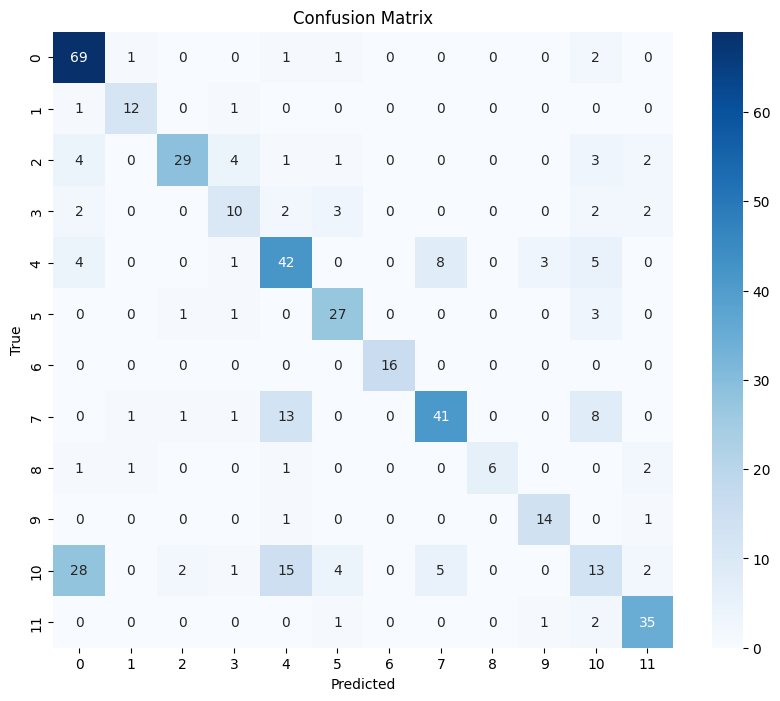

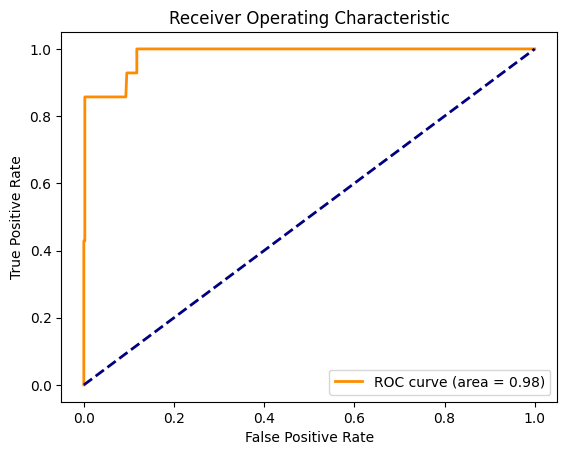

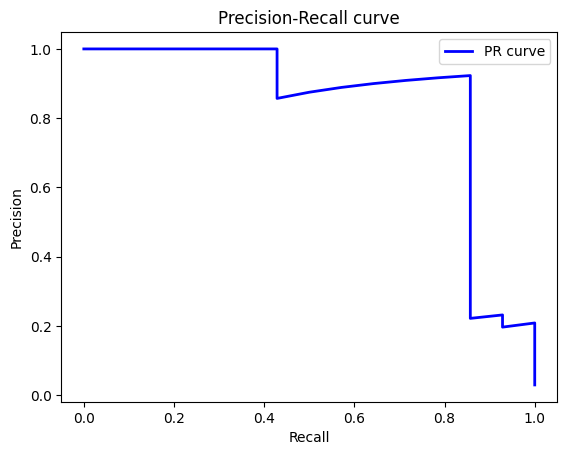

In [29]:
# Modeli değerlendirme
predictions, pred_labels, cm, accuracy, precision, recall, f1 = evaluate_model(trainer, test_dataset, test_labels)

# Karışıklık matrisini görselleştirme
plot_confusion_matrix(cm)

# ROC eğrisini görselleştirme
plot_roc_curve(test_labels, predictions)

# PR eğrisini görselleştirme
plot_pr_curve(test_labels, predictions)

# Distilbert Base Uncased

In [30]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(data['label'].unique()))


train_encodings = tokenize_function(train_texts.tolist())
test_encodings = tokenize_function(test_texts.tolist())

train_dataset = MedicalTranscriptionsDataset(train_encodings, train_labels)
test_dataset = MedicalTranscriptionsDataset(test_encodings, test_labels)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.052900,1.904152
2,1.240100,1.170516
3,0.698900,0.907029


TrainOutput(global_step=699, training_loss=1.4558492880181353, metrics={'train_runtime': 320.9342, 'train_samples_per_second': 17.377, 'train_steps_per_second': 2.178, 'total_flos': 738902431567872.0, 'train_loss': 1.4558492880181353, 'epoch': 3.0})

Accuracy: 0.6580645161290323
Precision: 0.6568515233023481
Recall: 0.6580645161290323
F1 Score: 0.6473044978488774


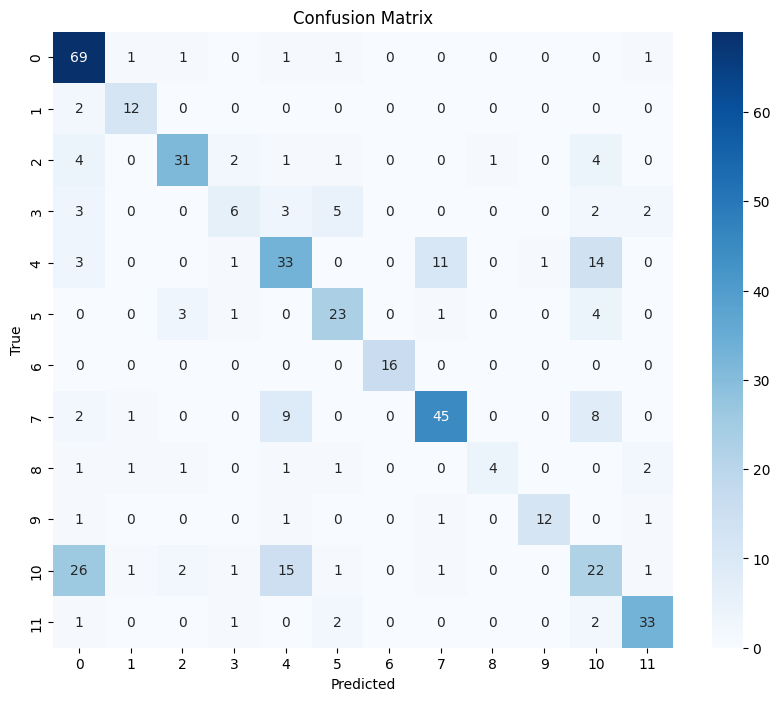

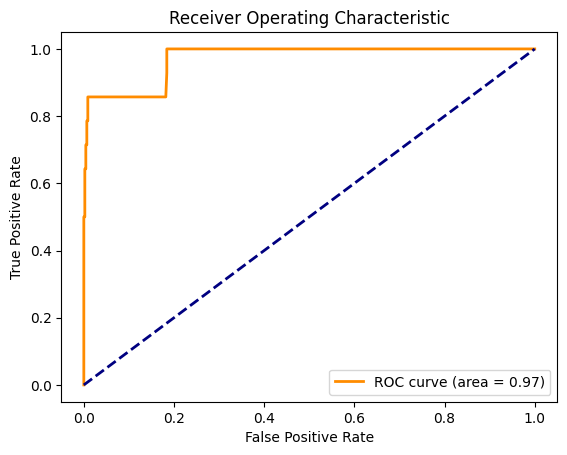

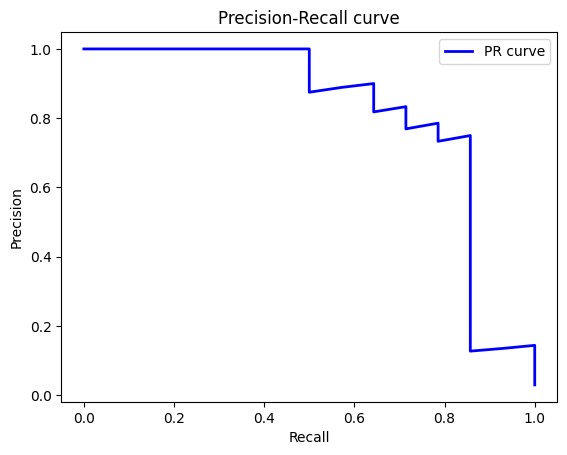

In [31]:
# Modeli değerlendirme
predictions, pred_labels, cm, accuracy, precision, recall, f1 = evaluate_model(trainer, test_dataset, test_labels)

# Karışıklık matrisini görselleştirme
plot_confusion_matrix(cm)

# ROC eğrisini görselleştirme
plot_roc_curve(test_labels, predictions)

# PR eğrisini görselleştirme
plot_pr_curve(test_labels, predictions)